##  Volume of water and tracer mass upwelled onto the shelf

In [1]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('paper')
sns.set_style('white')

In [3]:
def plotCanyonPos(ax,UpX,DnX):
    ax.axvline(UpX,color='0.70',linestyle='--')
    ax.axvline(DnX,color='0.70',linestyle='--')
def HCW_Tracer_AlongShelf(Tr,Tr1,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
  Tr1Mask=np.ma.array(Tr1,mask=maskExp)   
    
  trlim1 = TrMask[0,nzlim,yi,xi]
  trlim2 = TrMask[0,nzlim+1,yi,xi]
  trlim = (trlim1+trlim2)/2
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*Tr1Mask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

In [4]:
# Constants and scales
L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh=97.5 # head depth
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)



In [5]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc' 
CGridOut = Dataset(CGrid)

CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc' 
CGridNoCOut = Dataset(CGridNoC)

State = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
StateNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc' 

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' 
PtracersOut = Dataset(Ptracers)

Ptracers3D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03/ptracersGlob.nc' 
PtracersOut3D = Dataset(Ptracers3D)

PtracersHD = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/ptracersGlob.nc' 
PtracersOutHD = Dataset(PtracersHD)

PtracersNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 
PtracersOutNoC = Dataset(PtracersNoC)

PtracersNoCHD = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run40/ptracersGlob.nc' 
PtracersOutNoCHD = Dataset(PtracersNoCHD)


In [6]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =22, 3D = 4, total = 19)

rc = CGridNoCOut.variables['RC']
dxf = CGridNoCOut.variables['dxF']
xc = rout.getField(CGridNoC, 'XC') # x coords tracer cells
yc = rout.getField(CGridNoC, 'YC') # y coords tracer cells

rA = rout.getField(CGridNoC, 'rA') 

drF = CGridNoCOut.variables['drF'] # vertical distance between faces
drC = CGridNoCOut.variables['drC'] # vertical distance between centers

hFacC = rout.getField(CGridNoC, 'HFacC')
mask_NoC = rout.getMask(CGridNoC, 'HFacC')



times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [7]:
Tr1 = rout.getField(Ptracers, 'Tr1')
Tr1NoC = rout.getField(PtracersNoC, 'Tr1')

Tr2 = rout.getField(Ptracers, 'Tr2')
Tr2NoC = rout.getField(PtracersNoC, 'Tr2')

Tr13D = rout.getField(Ptracers3D, 'Tr1')
Tr23D = rout.getField(Ptracers3D, 'Tr2')

Tr1HD = rout.getField(PtracersHD, 'Tr1')
Tr1NoCHD = rout.getField(PtracersNoCHD, 'Tr1')

Tr2HD = rout.getField(PtracersHD, 'Tr2')
Tr2NoCHD = rout.getField(PtracersNoCHD, 'Tr2')

In [8]:
HCW,TrMass = HCW_Tracer_AlongShelf(Tr2,Tr1,mask_NoC,29,rA,hFacC,drF,227,30,180,50)

HCWNoC,TrMassNoc = HCW_Tracer_AlongShelf(Tr2NoC,Tr1NoC,mask_NoC,29,rA,hFacC,drF,227,30,180,50)

HCW3D,TrMass3D = HCW_Tracer_AlongShelf(Tr23D,Tr13D,mask_NoC,29,rA,hFacC,drF,227,30,180,50)
HCWHD,TrMassHD = HCW_Tracer_AlongShelf(Tr2HD,Tr1HD,mask_NoC,29,rA,hFacC,drF,227,30,180,50)

HCWNoCHD,TrMassNocHD = HCW_Tracer_AlongShelf(Tr2NoCHD,Tr1NoCHD,mask_NoC,29,rA,hFacC,drF,227,30,180,50)

tracer limit concentration is:  7.30753135681
tracer limit concentration is:  7.30753135681
tracer limit concentration is:  7.30753135681
tracer limit concentration is:  7.30753135681
tracer limit concentration is:  7.30753135681


In [10]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [15]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii=ii+1
    
select_rec=[0,2,12,15,5,9,16]
labels = ['Base case',
          'highest $\kappa_{bg}$',
          'high $\kappa_{can}$',
          'highest $\kappa_{can}$',
          'lower $N$',
          'lowest $f$',
          'lowest $U$',
          ]
colors = ['0.4','k','k','k','0.4','0.4','0.6']
line_sty = ['-','-','--',':','--',':','-']

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run67
7 CNTDIFF_run51
8 CNTDIFF_run69
9 CNTDIFF_run71
10 3DVISC_run01
11 3DVISC_run02
12 3DVISC_run03
13 3DVISC_run04
14 3DVISC_run05
15 3DVISC_run06
16 LOWEST_BF_run01
17 LOWEST_BF_run03
18 LOWEST_BF_run07
19 LOWEST_BF_run11


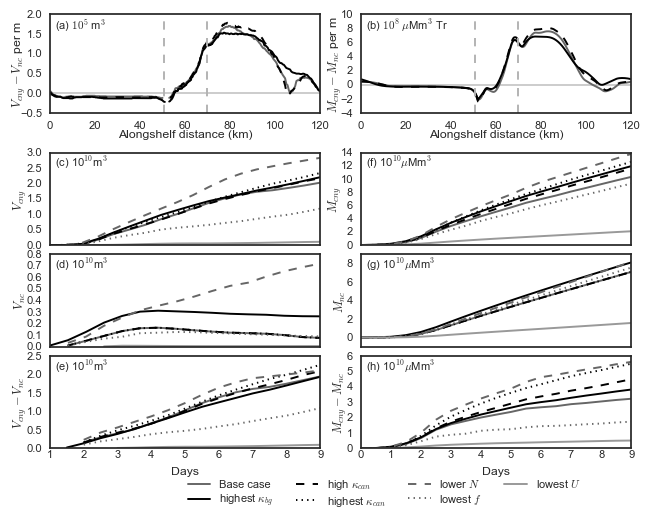

In [20]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.5,5.6)) # 190mm = 7.5in, 115cm = 4.52in

gs = gspec.GridSpec(2, 2,wspace=0.15,height_ratios=[1,3])

gs1 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1,0],hspace=0.1 )
gs2 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1,1],hspace=0.1)

ax0 = plt.subplot(gs1[0,0],xticks=[])
ax1 = plt.subplot(gs1[1,0],xticks=[])
ax2 = plt.subplot(gs1[2,0])
ax3 = plt.subplot(gs2[0,0],xticks=[])
ax4 = plt.subplot(gs2[1,0],xticks=[])
ax5 = plt.subplot(gs2[2,0])
ax6 = plt.subplot(gs[0,0])
ax7 = plt.subplot(gs[0,1])

jj = 0

for ind in select_rec:
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    ax0.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax3.plot(np.arange(0,19,1)/2.0,
             (dfcan['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0])/1E10,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    
    ax1.plot(np.arange(0,19,1)/2.0,
             (dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax4.plot(np.arange(0,19,1)/2.0,
             (dfnoc['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0])/1E10,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    
    ax2.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19]-dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax5.plot(np.arange(0,19,1)/2.0,
             (dfcan['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0:19])/1E10,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    jj=jj+1
    
# -  --------------------------------------------------------------------------------------------
ii = 7
ax6.axhline(0,color='0.8')
ax6.plot(xc[1,:]/1000,(HCW[ii,:]-HCWNoC[ii,:])/(100000*dxf[0,:]),
         color='0.4',linestyle='-')
ax6.plot(xc[1,:]/1000,(HCWHD[ii,:]-HCWNoCHD[ii,:])/(100000*dxf[0,:]),
         sns.xkcd_rgb["black"],linestyle='-')
ax6.plot(xc[1,:]/1000,(HCW3D[ii,:]-HCWNoC[ii,:])/(100000*dxf[0,:]),
         sns.xkcd_rgb["black"],linestyle='--')

ax7.axhline(0,color='0.8')
ax7.plot(xc[1,:]/1000,(TrMass[ii,:]-TrMassNoc[ii,:])/(100000000*dxf[0,:]),'-',
        color='0.4')
ax7.plot(xc[1,:]/1000,(TrMassHD[ii,:]-TrMassNocHD[ii,:])/(100000000*dxf[0,:]),'-',
         color=sns.xkcd_rgb["black"])
ax7.plot(xc[1,:]/1000,(TrMass3D[ii,:]-TrMassNoc[ii,:])/(100000000*dxf[0,:]),'--',
         color=sns.xkcd_rgb["black"])

plotCanyonPos(ax6,xc[1,120]/1000,xc[1,240]/1000)
plotCanyonPos(ax7,xc[1,120]/1000,xc[1,240]/1000)


ax7.text(0.02,0.85,'(b) $10^8$ $\mu$Mm$^3$ Tr',transform=ax7.transAxes)    
ax6.text(0.02,0.85,'(a) $10^5$ m$^3$',transform=ax6.transAxes)

# ----------------------------------------------------------------------------------------------

ax0.text(0.02,0.85,'(c) 10$^{10}$m$^3$',transform=ax0.transAxes)
ax1.text(0.02,0.85,'(d) 10$^{10}$m$^3$',transform=ax1.transAxes)    
ax2.text(0.02,0.85,'(e) 10$^{10}$m$^3$',transform=ax2.transAxes)
ax3.text(0.02,0.85,'(f) 10$^{10}$$\mu$Mm$^3$',transform=ax3.transAxes)    
ax4.text(0.02,0.85,'(g) 10$^{10}$$\mu$Mm$^3$',transform=ax4.transAxes)
ax5.text(0.02,0.85,'(h) 10$^{10}$$\mu$Mm$^3$',transform=ax5.transAxes)    


ax0.set_ylabel('$V_{cny}$ ',labelpad=-1)
ax1.set_ylabel('$V_{nc}$ ',labelpad=-1)
ax2.set_ylabel('$V_{cny}-V_{nc}$ ',labelpad=-1)
ax2.set_xlabel('Days')

ax3.set_ylabel('$M_{cny}$ ',labelpad=-2)
ax4.set_ylabel('$M_{nc}$ ',labelpad=-1)
ax5.set_ylabel('$M_{cny}-M_{nc}$ ',labelpad=-1)


ax5.set_xlabel('Days')

ax2.legend(bbox_to_anchor=(2,-0.2),ncol=4,labelspacing=0.1)

ax5.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax0.tick_params(axis='x', pad=0.1)
ax1.tick_params(axis='x', pad=0.1)

ax6.set_xlabel('Alongshelf distance (km)',labelpad=-1)
ax7.set_xlabel('Alongshelf distance (km)',labelpad=-1)

ax6.set_ylabel('$V_{cny}-V_{nc}$ per m',labelpad=-5)
ax7.set_ylabel('$M_{cny}-M_{nc}$ per m ',labelpad=-2)

plt.savefig('fig_HCW_TrMass_CanNoC.eps',format='eps',bbox_inches='tight')


In [22]:
print ("\t".join(['run name', 'Total HCW', 'CanyonHCW', 'CoastalHCW',  'Total TrMass', 'CanyonTrMass', 'CoastalTrMass']))

select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
for ind in select_rec:
    
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
  
    print ("%s\t%s" % ((records[ind].name), 
         "\t".join(['%.3e\t%.3f\t\t%.3f\t\t%.3e\t%.3f\t\t%.3f\t' % (dfcan['HCW'][18],
                                                              (dfcan['HCW'][18]-dfnoc['HCW'][18])/dfcan['HCW'][18],
                                                              dfnoc['HCW'][18]/dfcan['HCW'][18],
                                                              dfcan['TrMassHCW'][18],
                                                              (dfcan['TrMassHCW'][18]-dfnoc['TrMassHCW'][18])/dfcan['TrMassHCW'][18],
                                                              dfnoc['TrMassHCW'][18]/dfcan['TrMassHCW'][18])])))



run name	Total HCW	CanyonHCW	CoastalHCW	Total TrMass	CanyonTrMass	CoastalTrMass
CNTDIFF_run38	2.023e+10	0.962		0.038		1.605e+11	0.964		0.036	
CNTDIFF_run37	2.028e+10	0.955		0.045		1.517e+11	0.955		0.045	
CNTDIFF_run36	2.201e+10	0.880		0.120		1.258e+11	0.856		0.144	
CNTDIFF_run45	1.515e+10	0.967		0.033		1.166e+11	0.968		0.032	
CNTDIFF_run73	7.581e+09	0.947		0.053		5.752e+10	0.948		0.052	
CNTDIFF_run75	2.830e+10	0.746		0.254		2.369e+11	0.774		0.226	
CNTDIFF_run67	2.075e+10	0.955		0.045		1.655e+11	0.958		0.042	
CNTDIFF_run51	1.612e+10	0.951		0.049		1.247e+11	0.952		0.048	
CNTDIFF_run69	1.826e+10	0.959		0.041		1.428e+11	0.961		0.039	
CNTDIFF_run71	1.182e+10	0.924		0.076		9.040e+10	0.925		0.075	
3DVISC_run01	2.171e+10	0.966		0.034		1.770e+11	0.969		0.031	
3DVISC_run02	2.030e+10	0.964		0.036		1.623e+11	0.966		0.034	
3DVISC_run03	2.167e+10	0.965		0.035		1.754e+11	0.967		0.033	
3DVISC_run04	2.020e+10	0.962		0.038		1.603e+11	0.964		0.036	
3DVISC_run05	2.307e+10	0.967		0.033		1.930e+11	0.970		0.

In [29]:
print ("\t".join(['$Ro$&','$N_o$&','$\kappa_{can}$&', 'Total HCW $10^{10}$ m$^3$&', 
                  'CanyonHCW&',  'TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMassHCW&',
                  'TotalTrMass $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMass ' ]))

select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
for ind in select_rec:
    
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' 
            %(records[ind].exp_code,
              records[ind].exp_code,
              records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' 
               %(recordsNoC[ind].exp_code,
                 recordsNoC[ind].exp_code,
                 recordsNoC[ind].run_num))
    
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    print ("\t".join(['%0.3f\t&%0.2e\t&%0.1e\t&%.3f\t&%.3f\t\t&%.3f\t\t&%.3f\t&%.3f\t\t&%.3f\t ' 
                      % (Ro(records[ind].u,records[ind].f,R),records[ind].N,records[ind].kv,
                         dfcan['HCW'][18]/1E10,
                         (dfcan['HCW'][18]-dfnoc['HCW'][18])/dfcan['HCW'][18],
                         (dfcan['TrMassHCW'][18])/1E11,
                         (((dfcan['TrMassHCW'][18])-
                           (dfnoc['TrMassHCW'][18]))/(dfcan['TrMassHCW'][18])),
                         (dfcan['TotTrMass'][18])/1E11,
                         (((dfcan['TotTrMass'][18]-dfnoc['TotTrMass'][18]))/(dfcan['TotTrMass'][18])))
                     ]))
                                                              
                                                                                                    



$Ro$&	$N_o$&	$\kappa_{can}$&	Total HCW $10^{10}$ m$^3$&	CanyonHCW&	TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&	CanyonTrMassHCW&	TotalTrMass $10^{11}$ $\mu$Mm$^3$&	CanyonTrMass 
0.741	&5.50e-03	&1.0e-05	&2.023	&0.962		&1.605		&0.964	&9.852		&0.033	 
0.741	&5.50e-03	&1.0e-04	&2.028	&0.955		&1.517		&0.955	&9.869		&0.034	 
0.741	&5.50e-03	&1.0e-03	&2.201	&0.880		&1.258		&0.856	&10.015		&0.038	 
0.741	&6.30e-03	&1.0e-05	&1.515	&0.967		&1.166		&0.968	&9.664		&0.021	 
0.741	&7.40e-03	&1.0e-05	&0.758	&0.947		&0.575		&0.948	&9.487		&0.012	 
0.741	&4.50e-03	&1.0e-05	&2.830	&0.746		&2.369		&0.774	&10.200		&0.055	 
0.716	&5.50e-03	&1.0e-05	&2.075	&0.955		&1.655		&0.958	&9.862		&0.034	 
0.932	&5.50e-03	&1.0e-05	&1.612	&0.951		&1.247		&0.952	&9.795		&0.024	 
0.833	&5.50e-03	&1.0e-05	&1.826	&0.959		&1.428		&0.961	&9.821		&0.028	 
1.119	&5.50e-03	&1.0e-05	&1.182	&0.924		&0.904		&0.925	&9.750		&0.018	 
0.741	&5.50e-03	&1.0e-03	&2.171	&0.966		&1.770		&0.969	&9.979		&0.045	 
0.741	&5.50e-03	&1.0e-04	&2.030	&0.96

IndexError: list index out of range

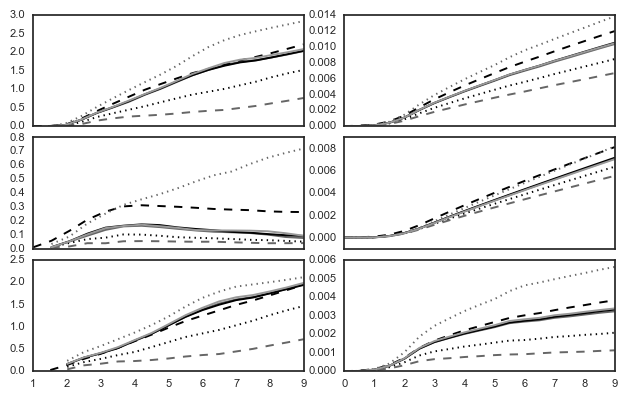

In [30]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.5,4.6)) # 190mm = 7.5in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2,wspace=0.15)
gs1 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0,0],hspace=0.1)
gs2 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0,1],hspace=0.1)

ax0 = plt.subplot(gs1[0,0],xticks=[])
ax1 = plt.subplot(gs1[1,0],xticks=[])
ax2 = plt.subplot(gs1[2,0])
ax3 = plt.subplot(gs2[0,0],xticks=[])
ax4 = plt.subplot(gs2[1,0],xticks=[])
ax5 = plt.subplot(gs2[2,0])

jj = 0

for ind in select_rec:
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    ax0.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax3.plot(np.arange(0,19,1)/2.0,
             (dfcan['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    
    ax1.plot(np.arange(0,19,1)/2.0,
             (dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax4.plot(np.arange(0,19,1)/2.0,
             (dfnoc['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    
    ax2.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19]-dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax5.plot(np.arange(0,19,1)/2.0,
             (dfcan['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0:19])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    jj=jj+1

ax0.text(0.01,0.90,'(a)',transform=ax0.transAxes)
ax1.text(0.01,0.90,'(b)',transform=ax1.transAxes)    
ax2.text(0.01,0.90,'(c)',transform=ax2.transAxes)
ax3.text(0.01,0.90,'(d)',transform=ax3.transAxes)    
ax4.text(0.01,0.90,'(e)',transform=ax4.transAxes)
ax5.text(0.01,0.90,'(f)',transform=ax5.transAxes)    


ax0.set_ylabel('$V_{cny}$ (10$^{10}$m$^3$)',labelpad=-2)
ax1.set_ylabel('$V_{nc}$ (10$^{10}$m$^3$)',labelpad=-2)
ax2.set_ylabel('$V_{cny}-V_{nc}$ (10$^{10}$m$^3$)',labelpad=-3)
ax2.set_xlabel('Days')

ax3.set_ylabel('$M_{cny}$ (10$^{13}$$\mu$mol)',labelpad=-2)
ax4.set_ylabel('$M_{cny}$ (10$^{13}$$\mu$mol)',labelpad=-2)
ax5.set_ylabel('$M_{cny}-M_{nc}$ (10$^{13}$$\mu$mol)',labelpad=-2)
ax5.set_xlabel('Days')

ax2.legend(bbox_to_anchor=(2,-0.2),ncol=4,labelspacing=0.1)

ax5.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)


#plt.savefig('fig_HCW_TrMass_CanNoC.eps',format='eps',bbox_inches='tight')


In [31]:
print ("\t".join(['run name', 'Total HCW', 'CanyonHCW', 'CoastalHCW',  'Total TrMass', 'CanyonTrMass', 'CoastalTrMass']))

select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
for ind in select_rec:
    
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
  
    print ("%s\t%s" % ((records[ind].name), 
         "\t".join(['%.3e\t%.3f\t\t%.3f\t\t%.3e\t%.3f\t\t%.3f\t' % (dfcan['HCW'][18],
                                                              (dfcan['HCW'][18]-dfnoc['HCW'][18])/dfcan['HCW'][18],
                                                              (dfnoc['HCW'][18])/dfcan['HCW'][18],
                                                              dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0],
                                                              (dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][18])/(dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0]),
                                                              (dfnoc['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0])/(dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0]))])))



run name	Total HCW	CanyonHCW	CoastalHCW	Total TrMass	CanyonTrMass	CoastalTrMass
CNTDIFF_run38	2.023e+10	0.962		0.038		1.031e+11	0.313		0.687	
CNTDIFF_run37	2.028e+10	0.955		0.045		1.048e+11	0.317		0.683	
CNTDIFF_run36	2.201e+10	0.880		0.120		1.194e+11	0.320		0.680	
CNTDIFF_run45	1.515e+10	0.967		0.033		8.429e+10	0.246		0.754	
CNTDIFF_run73	7.581e+09	0.947		0.053		6.662e+10	0.169		0.831	
CNTDIFF_run75	2.830e+10	0.746		0.254		1.379e+11	0.407		0.593	
CNTDIFF_run67	2.075e+10	0.955		0.045		1.041e+11	0.325		0.675	
CNTDIFF_run51	1.612e+10	0.951		0.049		9.739e+10	0.239		0.761	
CNTDIFF_run69	1.826e+10	0.959		0.041		9.999e+10	0.273		0.727	
CNTDIFF_run71	1.182e+10	0.924		0.076		9.293e+10	0.187		0.813	
3DVISC_run01	2.171e+10	0.966		0.034		1.158e+11	0.389		0.611	
3DVISC_run02	2.030e+10	0.964		0.036		1.072e+11	0.339		0.661	
3DVISC_run03	2.167e+10	0.965		0.035		1.158e+11	0.388		0.612	
3DVISC_run04	2.020e+10	0.962		0.038		1.071e+11	0.338		0.662	
3DVISC_run05	2.307e+10	0.967		0.033		1.266e+11	0.440		0.